# Week 7 Notebook: Model training, hyperparameter tuning, and model evaluation
The goal of this week's assignment is to use a second modeling method with 3 different hyperparameter settings of the method. 

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error


### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

data_folder = os.path.join(parent_dir,"data")
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [3]:
# X data path
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')
# Y data path
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

In [4]:
# Reading the parquet files as dataframes
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

### Regression Tree
First, we tried to fit a regression tree model on our data without tuning any hyperparamters.

In [5]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [6]:
# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [7]:
# Predicting on training and test sets
y_train_pred_tree = dtr.predict(X_train_scaled)
y_test_pred_tree = dtr.predict(X_test_scaled)
y_val_pred_tree = dtr.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print testing metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 0.1008, RMSE: 0.3175, R²: 1.0000

Decision Tree Regression Model - Validation Metrics:
MSE: 5.9150, RMSE: 2.4321, R²: 0.9993

Decision Tree Regression Model - Validation Metrics:
MSE: 5.9150, RMSE: 2.4321, R²: 0.9993


It's clear from training and validation metrics that the tree is overfitting to the training data without tuning any hyperparameters.

In [8]:
# Get the actual params of some parameters to get a sense of the range of hyperparameters we can experiment for
# 1. Actual depth of the tree
actual_depth = dtr.tree_.max_depth
print("Actual Depth:", actual_depth)

# 2. Number of leaves
num_leaves = dtr.tree_.n_leaves
print("Number of Leaves:", num_leaves)

# 3. Total number of nodes
node_count = dtr.tree_.node_count
print("Total Number of Nodes:", node_count)

Actual Depth: 52
Number of Leaves: 31099
Total Number of Nodes: 62197


### Hyperparameter Tuning

In [9]:
param_grid = {
    'max_depth': [5, 10, 20, 30],   # Limit the tree depth
    'min_samples_split': [2, 5, 10, 20],  # Increase the minimum samples required to split
    'min_samples_leaf': [5, 10, 15] # Increase the minimum samples per leaf
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 5}


In [10]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.3137, RMSE: 1.5211, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.3836, RMSE: 1.8395, R²: 0.9996

Decision Tree Regression Model - Test Metrics:
MSE: 3.3481, RMSE: 1.8298, R²: 0.9997


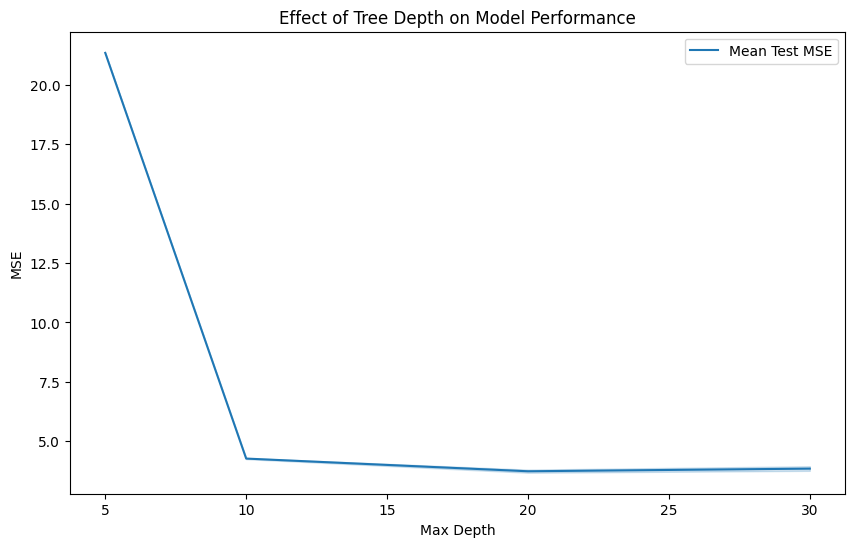

In [11]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)


# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='Mean Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

#### Pruning
Based on the metrics, the tree is still a bit overfitting to the training dataset. Therefore, we want to tune the ccp alpha to prune the tree to balance the complexity of the tree and its performance on unseen data.

In [12]:
# Update the hyperparameter grid to include smaller depths, and larger sample splits/leaves
param_grid = {
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 7],  # Increase the minimum samples required to split a node to prevent the tree from growing too deep
    'min_samples_leaf': [5, 10, 15],  # Increase the minimum samples required in a leaf node to make the tree more generalized
    'ccp_alpha': [0.001, 0.01, 0.1]  # Increase pruning to avoid overly complex trees
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 7}


In [13]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")  # Add this block for validation metrics
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.6747, RMSE: 1.6354, R²: 0.9997

Decision Tree Regression Model - Test Metrics:
MSE: 3.1037, RMSE: 1.7617, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.0933, RMSE: 1.7588, R²: 0.9996


As the result of pruning, the tree performs both better on the training data and the unseen data.

In [14]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)
results.replace([np.inf, -np.inf], np.nan, inplace=True)

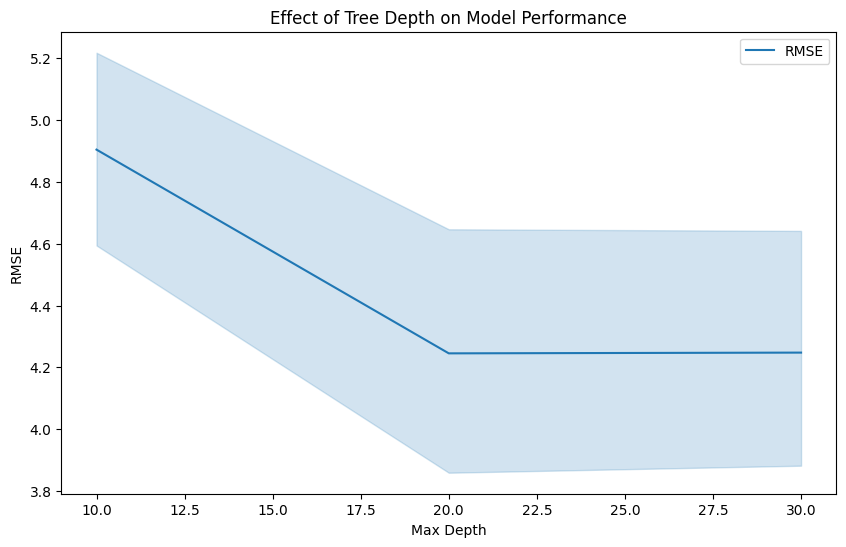

In [15]:
# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

In [16]:
# Get the feature importances from the best tree
feature_importances = best_tree.feature_importances_

# Create a DataFrame to display feature importance
features_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(features_df)

                         Feature  Importance
56       source_Theatre_District    0.448084
68  destination_Theatre_District    0.401320
78                     name_Taxi    0.141510
71                name_Black_SUV    0.002291
74             name_Lux_Black_XL    0.002279
..                           ...         ...
35                temperatureMin    0.000000
36            temperatureMinTime    0.000000
38            temperatureMaxTime    0.000000
43                     rush_hour    0.000000
42    apparentTemperatureMaxTime    0.000000

[84 rows x 2 columns]
